In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [3]:
# Cargar el dataset
data = pd.read_csv('/content/drive/MyDrive/UBA/Trabajo de grado/dataset.csv')

  # Mostrar las primeras filas del dataset
print(data.head())

          P         D          L          R P_fuzzy_set  P_membership  \
0  0.469889 -0.178362  -7.911369  39.596394       cerca      0.883518   
1 -0.488971 -0.017334  67.120945 -18.247367       lejos      0.851716   
2 -0.957817  0.008056  73.954778 -19.566773   muy lejos      0.929694   
3 -0.950883  0.925550  62.284570  -4.455604   muy lejos      0.918138   
4  0.020582  0.554227 -14.095086  65.161138          ok      0.948545   

   D_fuzzy_set  D_membership                    L_fuzzy_set  L_membership  \
0   alejandose      0.891810          muy lento hacia atrás      0.895568   
1   sin cambio      0.913331      rápidamente hacia delante      0.643953   
2   sin cambio      0.959718  bastante rápido hacia delante      0.697739   
3  acercandose      1.000000      rápidamente hacia delante      0.885771   
4  acercandose      1.000000          muy lento hacia atrás      0.795246   

                 R_fuzzy_set  R_membership  \
0    despacito hacia delante      0.520180   
1     

In [4]:
X = data[['P','D','L','R','CAT']]
y = data['FRASE']
z = data[['P_fuzzy_set', 'D_fuzzy_set', 'L_fuzzy_set', 'R_fuzzy_set']].apply(lambda x: ' '.join(x), axis=1)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(y)
num_decoder_tokens = len(tokenizer.word_index) + 1
y_tokenized = tokenizer.texts_to_sequences(y)

In [6]:
from sklearn.model_selection import train_test_split

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_tokenized, stratify = data['CAT'], test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Obtener el índice de las filas de X_train, X_val y X_test
idx_train = X_train.index
idx_val = X_val.index
idx_test = X_test.index


In [7]:
# Dividir z en z_train, z_val y z_test
z_train = z.loc[idx_train].values
z_val = z.loc[idx_val].values
z_test = z.loc[idx_test].values

In [8]:
z_train = tokenizer.texts_to_sequences(z_train)
z_val = tokenizer.texts_to_sequences(z_val)
z_test = tokenizer.texts_to_sequences(z_test)


In [9]:
X_train = X_train[['P','D','L','R']].values
X_val = X_val[['P','D','L','R']].values
X_test = X_test[['P','D','L','R']].values

In [10]:
from sklearn.preprocessing import StandardScaler

# Ajusta las columnas numéricas con StandardScaler
scaler_values = StandardScaler()

scaler_values.fit(X_train)

StandardScaler()

In [11]:
X_train_scaled = scaler_values.transform(X_train)
X_val_scaled =scaler_values.transform(X_val)
X_test_scaled =scaler_values.transform(X_test)

In [12]:
max_len = max(len(s) for s in y_tokenized)

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


y_train = pad_sequences(y_train, maxlen=max_len, padding='post', truncating='post')
y_val = pad_sequences(y_val, maxlen=max_len, padding='post', truncating='post')
y_test = pad_sequences(y_test, maxlen=max_len, padding='post', truncating='post')
z_train = pad_sequences(z_train, maxlen=max_len, padding='post', truncating='post')
z_val = pad_sequences(z_val, maxlen=max_len, padding='post', truncating='post')
z_test = pad_sequences(z_test, maxlen=max_len, padding='post', truncating='post')

In [14]:
print('tamaño X train_scaled', X_train_scaled.shape)
print('tamaño y train', y_train.shape)
print('tamaño z train', z_train.shape)


print('tamaño X val_scaled', X_val_scaled.shape)
print('tamaño y val', y_val.shape)
print('tamaño z val_scaled', z_val.shape)

print('tamaño X test_scaled', X_test_scaled.shape)
print('tamaño y test', y_test.shape)
print('tamaño z test', z_test.shape)

tamaño X train_scaled (5999, 4)
tamaño y train (5999, 34)
tamaño z train (5999, 34)
tamaño X val_scaled (2000, 4)
tamaño y val (2000, 34)
tamaño z val_scaled (2000, 34)
tamaño X test_scaled (2000, 4)
tamaño y test (2000, 34)
tamaño z test (2000, 34)


In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Definir callbacks
callbacks = [
    #ModelCheckpoint(filepath='modelo_ep{epoch:02d}_loss{val_loss:.4f}.h5',
    #                monitor='val_loss',
    #                save_best_only=True,
    #                mode='min',
    #                save_weights_only=True,
    #                verbose=1),
    EarlyStopping(monitor='val_loss',
                  patience=4,
                  verbose=1)
]

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# Definir dimension de entrada para el encoder
encoder_inputs = Input(shape=(1, 4))

# Capa LSTM  en el encoder
encoder_lstm = LSTM(64, return_state=True)
encoder_output, state_h, state_c = encoder_lstm(encoder_inputs)

# Se descartan las salidas del encoder y solo se toman los estados
encoder_states = [state_h, state_c]


In [17]:
# Definir dimension de entrada para el decoder
decoder_inputs = Input(shape=(None,))

# Capa de embedding en el decoder
decoder_embedding = Embedding(max_len, output_dim=100)
decoder_inputs_embedded = decoder_embedding(decoder_inputs)

# Capa LSTM 1 en el decoder, con los estados del encoder como inicialización
decoder_lstm1 = LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm1(decoder_inputs_embedded, initial_state=encoder_states)

# Capa densa con activación softmax en el output
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Definir modelo encoder-decoder
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


In [18]:
history = model.fit([X_train_scaled.reshape(5999,1,4), z_train], 
    y_train.reshape(y_train.shape[0], y_train.shape[1], 1),
     batch_size=64, 
     epochs=200, 
     validation_data=([X_val_scaled.reshape(X_val.shape[0],1,4), z_val], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)))

loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/200
94/94 [==============================] - 12s 21ms/step - loss: 3.0363 - val_loss: 2.5577
Epoch 2/200
94/94 [==============================] - 1s 9ms/step - loss: 2.3145 - val_loss: 2.0815
Epoch 3/200
94/94 [==============================] - 1s 11ms/step - loss: 1.8837 - val_loss: 1.6806
Epoch 4/200
94/94 [==============================] - 1s 12ms/step - loss: 1.5582 - val_loss: 1.4028
Epoch 5/200
94/94 [==============================] - 1s 13ms/step - loss: 1.3466 - val_loss: 1.2431
Epoch 6/200
94/94 [==============================] - 1s 9ms/step - loss: 1.1870 - val_loss: 1.1735
Epoch 7/200
94/94 [==============================] - 1s 13ms/step - loss: 1.0857 - val_loss: 0.9944
Epoch 8/200
94/94 [==============================] - 1s 13ms/step - loss: 0.9711 - val_loss: 0.8999
Epoch 9/200
94/94 [==============================] - 1s 11ms/step - loss: 0.8548 - val_loss: 0.8335
Epoch 10/200
94/94 [==============================] - 1s 9ms/step - loss: 0.8176 - val_loss: 0.7507
E

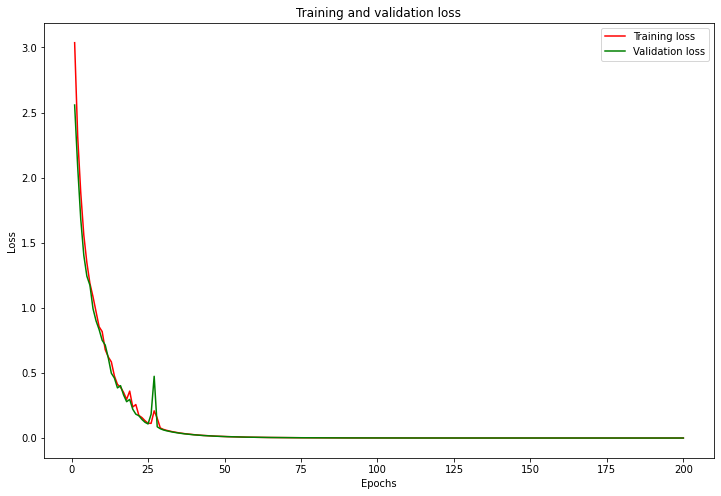

In [29]:
import matplotlib.pyplot as plt

# Crear el gráfico
plt.figure(figsize=(12, 8))
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='r', label='Training loss')
plt.plot(epochs, val_loss, color='g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
with open('/content/drive/MyDrive/parametros.txt', 'w') as file:
    
    for layer in model.layers:
        # Obtener los pesos y bias de la capa
        weights = layer.get_weights()
        if weights: # verificar si la lista no está vacía
            # Guardar los pesos y bias en el archivo de texto
            file.write(f'Capa: {layer.name}\n')
            file.write(f'Pesos: {weights[0]}\n')
            if len(weights) > 1:
                file.write(f'Bias: {weights[1]}\n')
            else:
                file.write('Advertencia: No se encontraron biases para esta capa\n')
        else:
            print(f'Advertencia: No se encontraron pesos para la capa {layer.name}')



Advertencia: No se encontraron pesos para la capa input_2
Advertencia: No se encontraron pesos para la capa input_1


In [30]:
model.evaluate([X_test.reshape(X_test.shape[0],1,4),z_test])

63/63 [==============================] - 0s 2ms/step - loss: 0.0000e+00


0.0

In [31]:
def predictions(preds):
    preds_words = []
    for i in range(preds.shape[0]):
        preds_row = preds[i]
        preds_row_words = []
        for idx in preds_row:
            if idx in tokenizer.index_word:
                preds_row_words.append(tokenizer.index_word[idx])
        preds_words.append(preds_row_words)

    return preds_words


  

In [32]:
preds = model.predict([X_test.reshape(X_test.shape[0],1,4), z_test])


63/63 [==============================] - 0s 4ms/step


In [33]:
y_test[0].shape

(34,)

In [34]:
preds = np.argmax(preds, axis=-1)

In [35]:
resul = preds == y_test

In [36]:
resul[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True])

In [37]:
frasesnlg = predictions(preds)
print(frasesnlg)

[['cuando', 'estés', 'lejos', 'la', 'la', 'pared', 'y', 'te', 'estás', 'alejando', 'más', 'de', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'bastante', 'rápido', 'hacia', 'delante', 'y', 'gira', 'tu', 'rueda', 'derecha', 'muy', 'hacia', 'hacia', 'atrás'], ['cuando', 'estés', 'muy', 'cerca', 'a', 'la', 'pared', 'pero', 'ni', 'te', 'acercas', 'más', 'ni', 'te', 'te', 'alejas', 'de', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'despacito', 'hacia', 'atrás', 'y', 'gira', 'tu', 'rueda', 'derecha', 'despacito', 'hacia', 'atrás'], ['cuando', 'estés', 'muy', 'cerca', 'a', 'la', 'pared', 'pared', 'pero', 'ni', 'te', 'acercas', 'más', 'ni', 'te', 'alejas', 'de', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'despacito', 'hacia', 'atrás', 'y', 'gira', 'tu', 'rueda', 'derecha', 'despacito', 'hacia', 'atrás'], ['cuando', 'estés', 'estés', 'lejos', 'de', 'la', 'pared', 'y', 'te', 'estás', 'alejando', 'más', 'de', 'ella', 'gira', 'tu', 'rueda', 'izquierda', 'bastante', 'rápido', 'hacia', 'delante', 'y'

# guardar el modelo y cargarlo despues

In [42]:
# Guarda el modelo
model.save('/content/drive/MyDrive/UBA/Trabajo de grado/Modelos/NLG_GeNeSys_vocab_limi.h5')